In [1]:
%reload_ext autoreload

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mvlearn.embed import MCCA
import umap


from sklearn.decomposition import PCA

from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_survival_prediction
from src.constants import RANDOM_STATE
from src.pipelines import classification_pipeline, regression_pipeline, cox_regression_pipeline
from src.autoencoder import EncoderPipeline

Загружаем обработанные данные по раку груди, выживаемости и клинические данные. Всего после предобработки - 620 пациентов. Делаем разделение на трейн и тест, в которые попадают одни и те же пациенты - для каждой модели.

In [3]:
survival_data_breast = pd.read_csv('data/breast/survival_data_breast.csv')
dna_breast = pd.read_csv('data/breast/expression_data_breast.csv', index_col=[0]).fillna(0.)
rna_breast = pd.read_csv('data/breast/mirna_data_breast.csv', index_col=[0]).fillna(0.)
methylation_breast = pd.read_csv('data/breast/methylation_data_breast.csv', index_col=[0]).fillna(0.)

mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast.csv')

assert (survival_data_breast['PatientID'] == mofa_data_breast['sample'].drop_duplicates()).all()
assert (clinical_data_breast['sampleID'] == mofa_data_breast['sample'].drop_duplicates()).all()

In [4]:
N_FACTORS = 20
TRAIN_INDICES, TEST_INDICES = split_patients_for_survival_prediction(survival_data_breast)

Из клинических данных вручную отобраны фичи, которые не связаны с таргетом, содержат более 80% непустых данных и более 1 уникального значения, и которые не являются техническими (названия файлов, идентификаторы и прочее)

In [5]:
CATEGORICAL_CLINICAL_FEATURES = [
                                 'anatomic_neoplasm_subdivision', 
                                 'axillary_lymph_node_stage_method_type',
                                 'breast_carcinoma_estrogen_receptor_status',
                                 'breast_carcinoma_progesterone_receptor_status',
                                 'breast_carcinoma_surgical_procedure_name',
                                 'gender',
                                 'histological_type',
                                 'history_of_neoadjuvant_treatment',
                                 'icd_10',
                                 'icd_o_3_histology',
                                 'icd_o_3_site',
                                 'initial_pathologic_diagnosis_method',
                                 'lab_proc_her2_neu_immunohistochemistry_receptor_status',
                                 'margin_status',
                                 'menopause_status',
                                 'new_tumor_event_after_initial_treatment',
                                 'oct_embedded',
                                 'pathologic_M',
                                 'pathologic_N',
                                 'pathologic_T',
                                 'pathologic_stage',
                                 'person_neoplasm_cancer_status',
                                 'primary_lymph_node_presentation_assessment',
                                 'radiation_therapy',
                                 'system_version',
                                 'tissue_prospective_collection_indicator',
                                 'tissue_retrospective_collection_indicator',
                                 'tissue_source_site']
NUMERICAL_CLINICAL_FEATURES = ['age_at_initial_pathologic_diagnosis',
                               'initial_weight', 'lymph_node_examined_count', 'number_of_lymphnodes_positive_by_he']
N_CATEGORICAL_CLINICAL = len(CATEGORICAL_CLINICAL_FEATURES)
N_NUMERIC_CLINICAL = len(NUMERICAL_CLINICAL_FEATURES)

In [6]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in CATEGORICAL_CLINICAL_FEATURES:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features.head()

,age_at_initial_pathologic_diagnosis,initial_weight,lymph_node_examined_count,number_of_lymphnodes_positive_by_he,anatomic_neoplasm_subdivision,axillary_lymph_node_stage_method_type,breast_carcinoma_estrogen_receptor_status,breast_carcinoma_progesterone_receptor_status,breast_carcinoma_surgical_procedure_name,gender,...,pathologic_N,pathologic_T,pathologic_stage,person_neoplasm_cancer_status,primary_lymph_node_presentation_assessment,radiation_therapy,system_version,tissue_prospective_collection_indicator,tissue_retrospective_collection_indicator,tissue_source_site
0,55.0,60.0,13.0,4.0,Left Lower Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,NX,TX,Stage X,WITH TUMOR,YES,NO,6th,NO,YES,3C
1,50.0,120.0,15.0,1.0,Right Upper Outer Quadrant,Sentinel lymph node biopsy plus axillary disse...,Positive,Positive,Lumpectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,YES,6th,NO,YES,3C
2,62.0,NaN,23.0,1.0,Right,missing,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N1a,T2,Stage IIB,TUMOR FREE,YES,NO,7th,NO,YES,3C
3,52.0,140.0,2.0,0.0,Right,Sentinel node biopsy alone,Positive,Positive,Simple Mastectomy,FEMALE,...,N0 (i+),T1c,Stage IA,TUMOR FREE,YES,NO,7th,NO,YES,3C
4,50.0,770.0,14.0,4.0,Left|Left Upper Outer Quadrant,Axillary lymph node dissection alone,Positive,Positive,Modified Radical Mastectomy,FEMALE,...,N2a,T2,Stage IIIA,TUMOR FREE,YES,NO,7th,YES,NO,4H


### Обучаем модели факторизации

MOFA

In [7]:
mofa_factors, weights, r2 = train_mofa(mofa_data_breast.copy(), RANDOM_STATE, factors=N_FACTORS)
clear_output()

MCCA

In [8]:
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)
mcca_factors = cca.fit_transform([dna_breast.values, rna_breast.values, methylation_breast.values])

PCA

In [9]:
X_breast_all = np.hstack([dna_breast.values, rna_breast.values, methylation_breast.values])

In [10]:
pca = PCA(n_components=N_FACTORS)
pca_factors = pca.fit_transform(X_breast_all)

UMAP

In [11]:
reducer = umap.UMAP(n_components=N_FACTORS, random_state=RANDOM_STATE)
umap_factors = reducer.fit_transform(X_breast_all)

Base Autoencoder - модель из статьи Deep Learning–Based Multi-Omics Integration Robustly Predicts Survival in Liver Cancer: 1 энкодер для всех 3х модальностей, сконкатенированных друг с другом, 1 скрытый линейный слой, ф-ция активации - tanh, dropout 0.5

In [12]:
%autoreload
base_enc_pipeline = EncoderPipeline([dna_breast.values, rna_breast.values, methylation_breast.values], N_FACTORS, RANDOM_STATE, base=True)
base_enc_pipeline.train()

clear_output()
base_autoenc_factors = base_enc_pipeline.encode()

Triple Autoencoder - дополненная мною архитектура: 3 отдельных экодера для каждой модельности, т.е. веса сначала подстраиваются под специфику модальности, и только затем объединяются. 2 скрытых линейный слоя, ф-ция активации ReLU (менее подвержена затухающему градиенту), батч-нормализация

In [13]:
%autoreload
triple_enc_pipeline = EncoderPipeline([dna_breast.values, rna_breast.values, methylation_breast.values], N_FACTORS, RANDOM_STATE)
triple_enc_pipeline.train()

clear_output()
triple_autoenc_factors = triple_enc_pipeline.encode()

In [14]:
pipeline_base_args = [clinical_features, survival_data_breast, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       X_breast_all.shape[1], N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

pipeline_args = [clinical_features, survival_data_breast, TRAIN_INDICES, TEST_INDICES, RANDOM_STATE,
                       N_FACTORS, N_NUMERIC_CLINICAL, NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

cox_pipeline_args = [clinical_features, survival_data_breast, TRAIN_INDICES, TEST_INDICES,
    NUMERICAL_CLINICAL_FEATURES, CATEGORICAL_CLINICAL_FEATURES]

## Классификация: предсказание смерти

### Бейзлайн: без факторизации

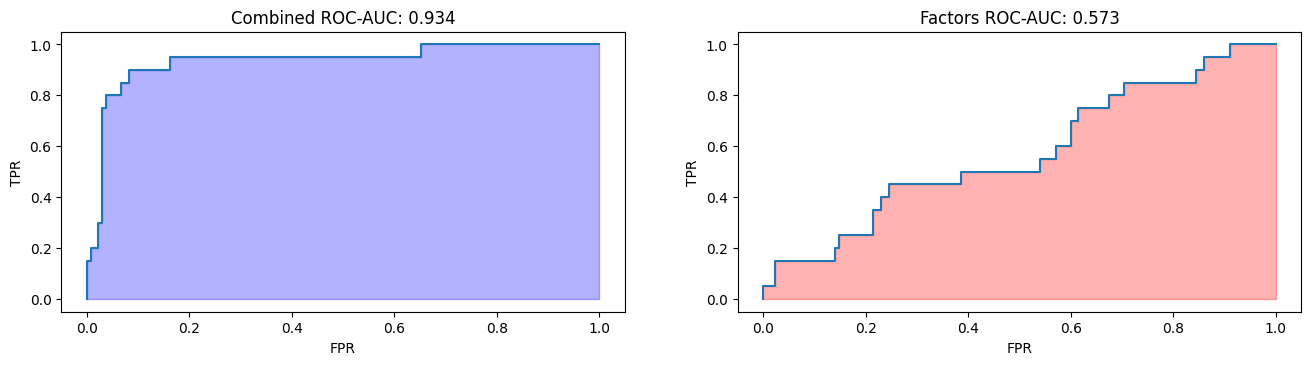

In [15]:
r_f_base, r_c_base = classification_pipeline(X_breast_all, *pipeline_base_args, plot_feat_imp=False)

### MOFA

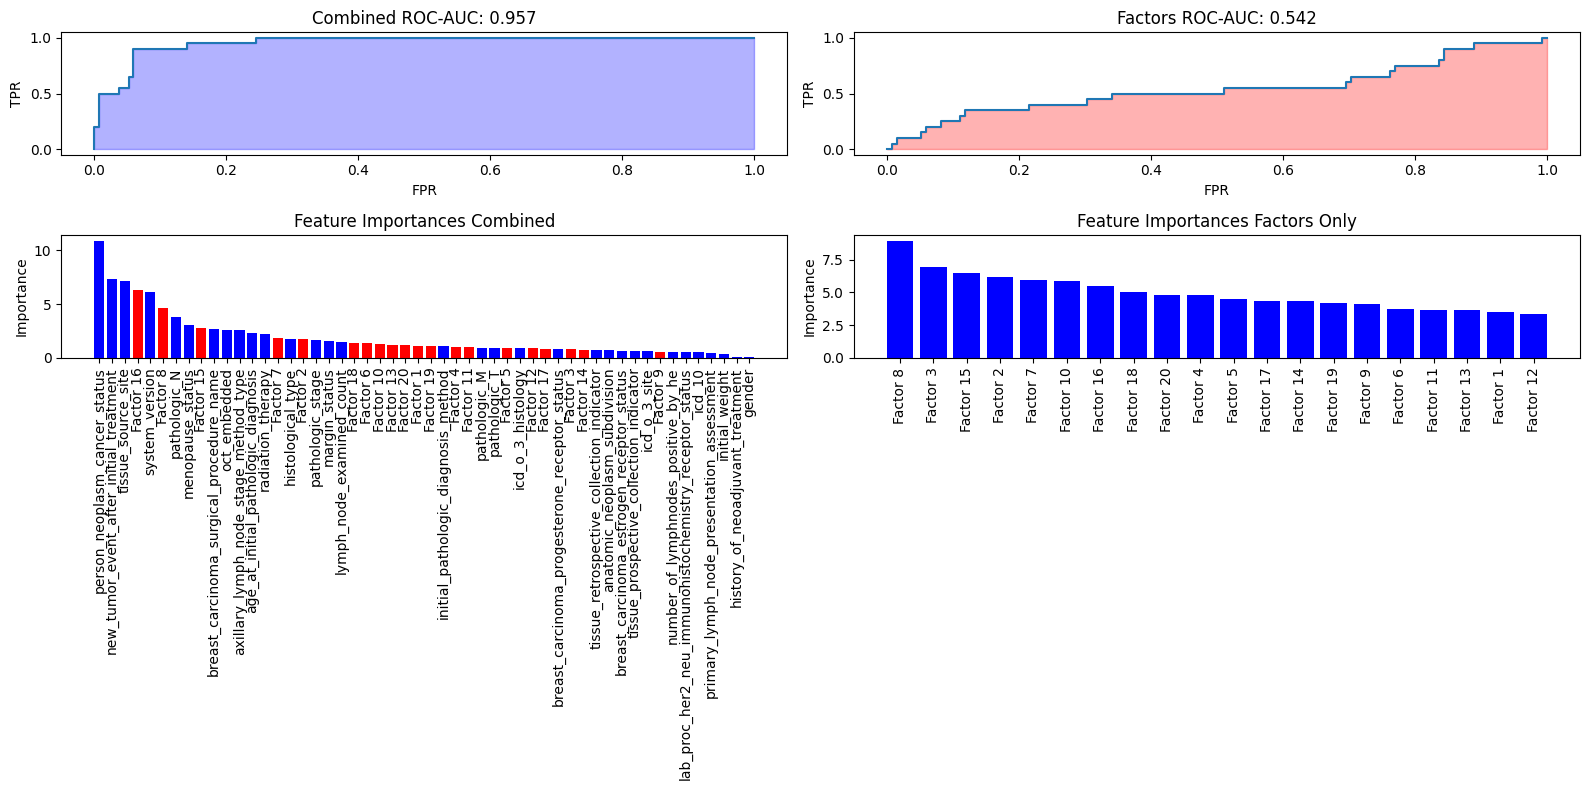

In [16]:
r_f_mofa, r_c_mofa, f_f_mofa, f_c_mofa = classification_pipeline(mofa_factors, *pipeline_args)

### MCCA

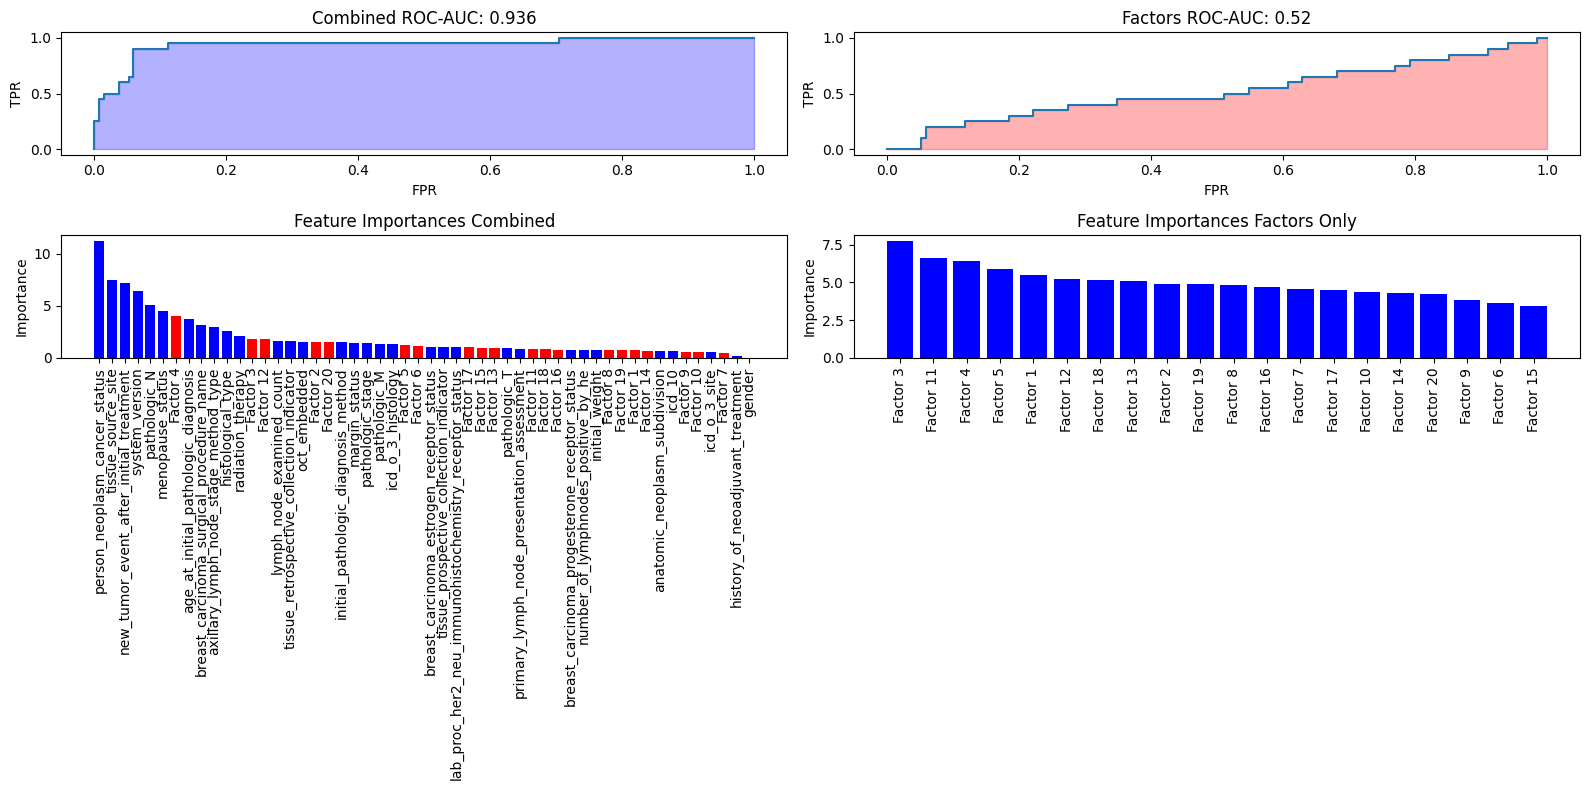

In [17]:
r_f_mcca, r_c_mcca, f_f_mcca, f_c_mcca = classification_pipeline(mcca_factors, *pipeline_args)

### PCA

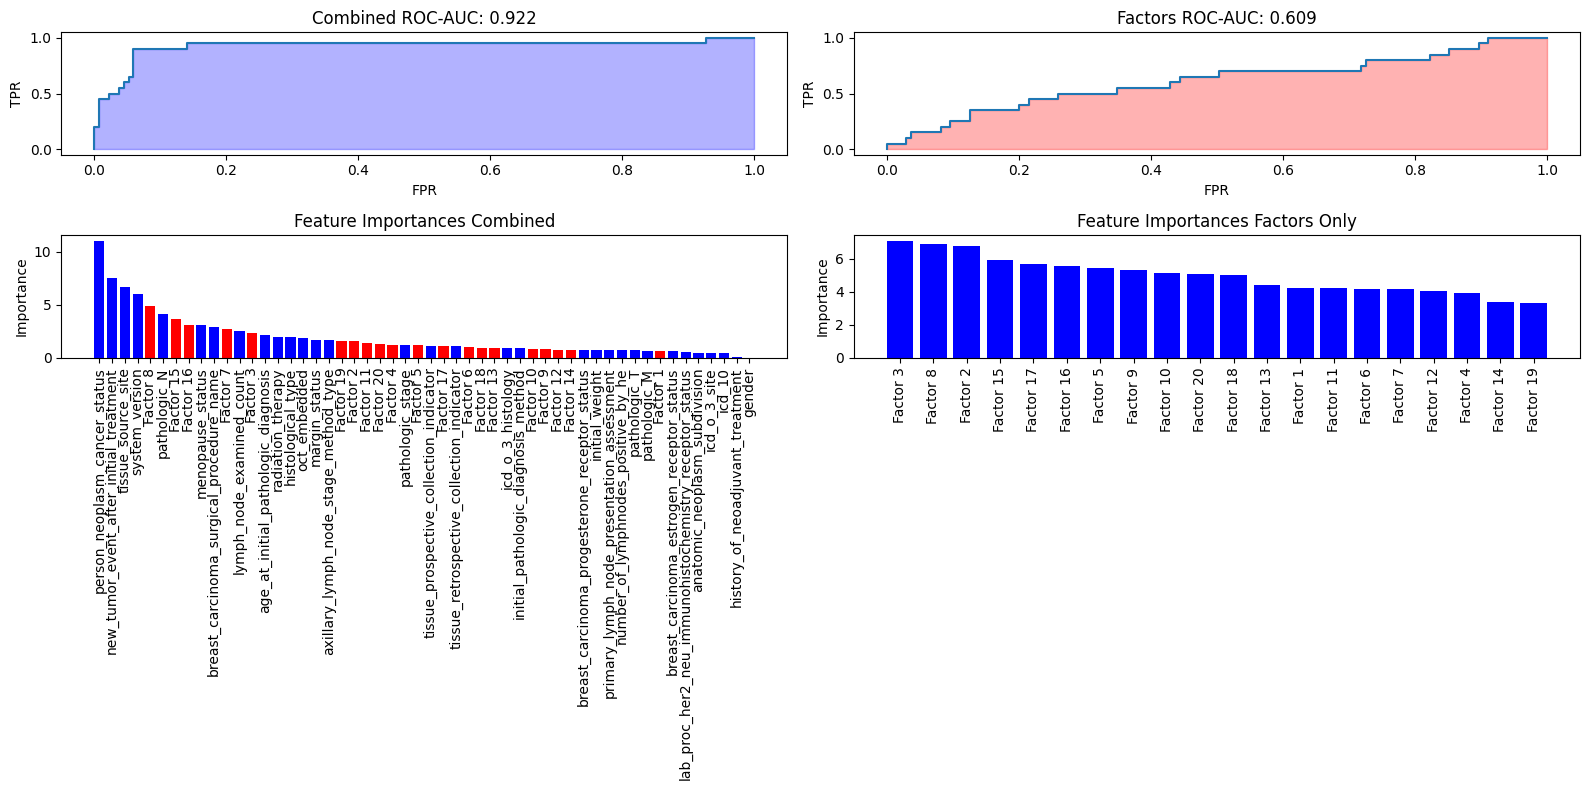

In [18]:
r_f_pca, r_c_pca, f_f_pca, f_c_pca = classification_pipeline(pca_factors, *pipeline_args)

### UMAP

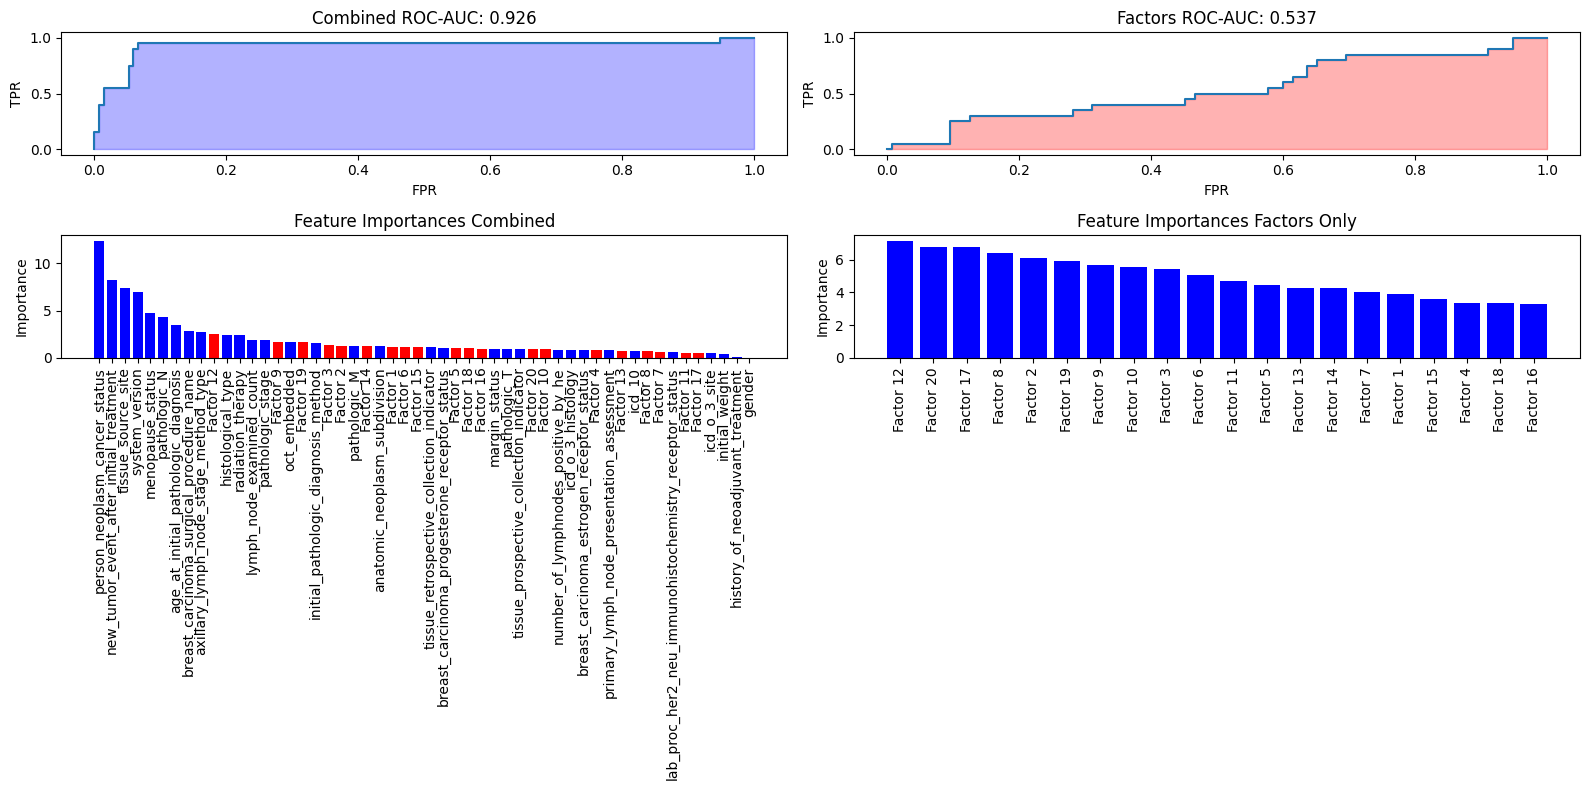

In [19]:
r_f_umap, r_c_umap, f_f_umap, f_c_umap = classification_pipeline(umap_factors, *pipeline_args)

### Base Autoencoder

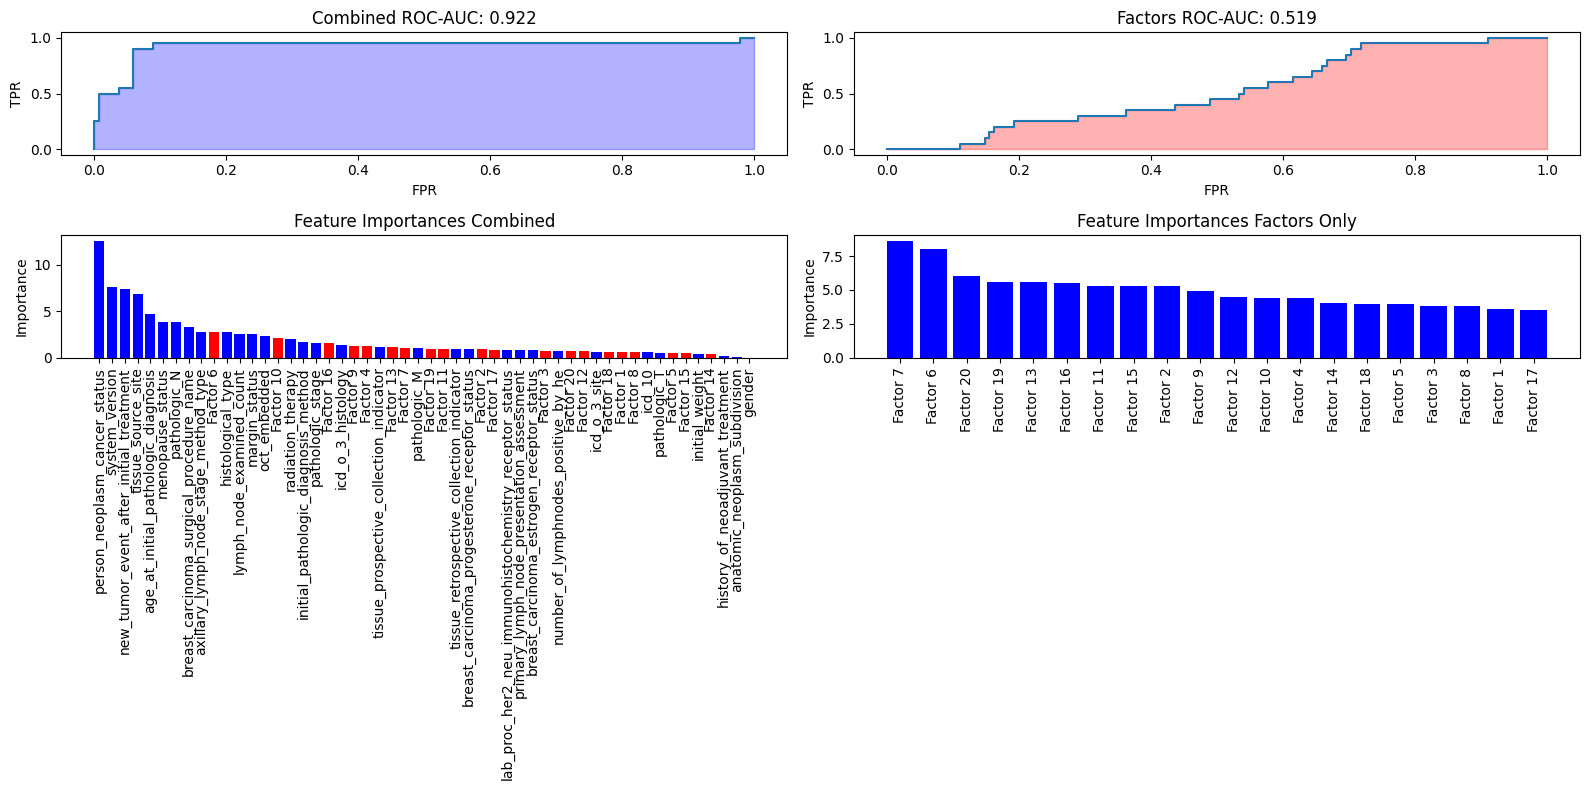

In [20]:
%autoreload
r_f_base_auto, r_c_base_auto, f_f_triple_auto, f_c_base_auto = classification_pipeline(base_autoenc_factors, *pipeline_args)

### Triple Autoencoder

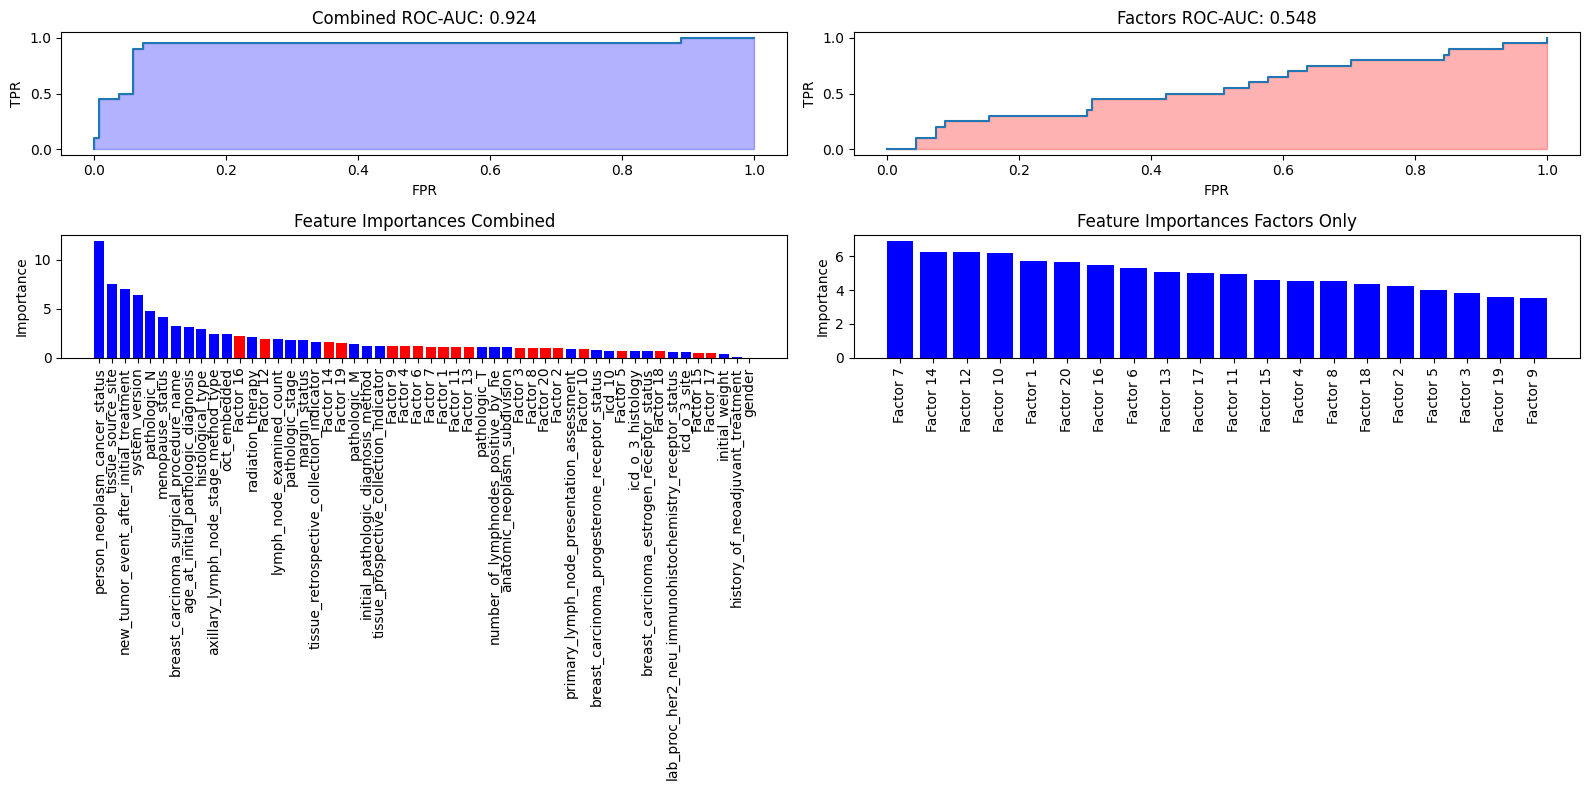

In [21]:
r_f_triple_auto, r_c_triple_auto, f_f_triple_auto, f_c_triple_auto = classification_pipeline(triple_autoenc_factors, *pipeline_args)

### Классификация, результаты:

In [37]:
class_results = pd.DataFrame({
    'ROC-AUC factors': [r_f_base, r_f_pca, r_f_umap, r_f_mofa, r_f_mcca, r_f_base_auto, r_f_triple_auto],
    'ROC-AUC factors + clinical': [r_c_base, r_c_pca, r_c_umap, r_c_mofa, r_c_mcca, r_c_base_auto, r_c_triple_auto],
}, index=['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder'])

class_results['Method Average'] = class_results.mean(axis=1)
means = class_results.iloc[:, :-1].mean(axis=0)
class_results.loc['All Methods Average'] = means.tolist() + ['-']

class_results

,ROC-AUC factors,ROC-AUC factors + clinical,Method Average
No factorization,0.572963,0.934074,0.753519
PCA,0.608889,0.922222,0.765556
UMAP,0.537407,0.925926,0.731667
MOFA,0.542222,0.956667,0.749444
MCCA,0.520000,0.935926,0.727963
Base Autoencoder,0.519259,0.922222,0.720741
Triple Autoencoder,0.547778,0.923704,0.735741
All Methods Average,0.549788,0.931534,-


### *В задаче предсказания смерти по факторам лучше всего оказались PCA и Base Autoencoder (почти наравне)*

## Регрессия: предсказание survival

### Бейзлайн: без факторизации

In [38]:
base_metrics = regression_pipeline(X_breast_all, *pipeline_base_args, plot_feat_imp=False)
m_f_base, m_c_base, c_f_base, c_c_base = base_metrics.values()

### MOFA

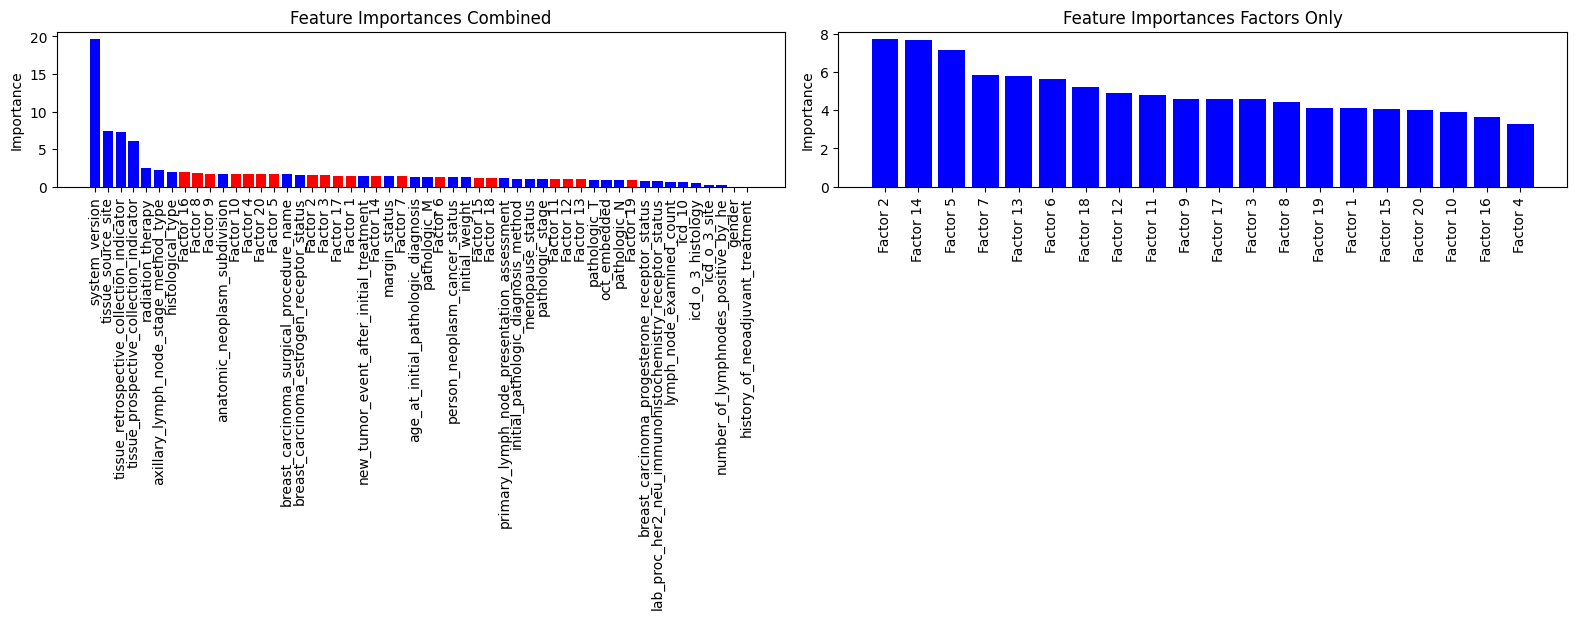

In [39]:
mofa_metrics = regression_pipeline(mofa_factors, *pipeline_args)
m_f_mofa, m_c_mofa, c_f_mofa, c_c_mofa = mofa_metrics.values()

### MCCA

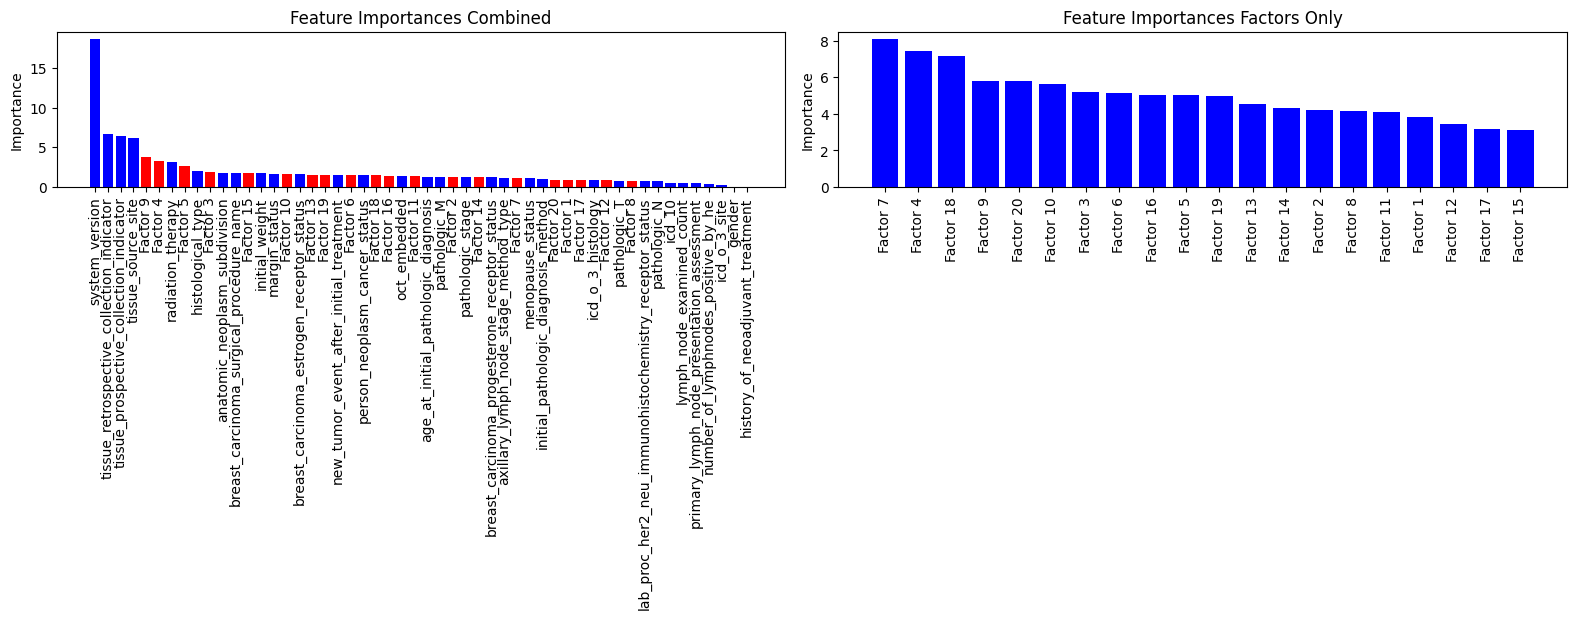

In [40]:
mcca_metrics = regression_pipeline(mcca_factors, *pipeline_args)
m_f_mcca, m_c_mcca, c_f_mcca, c_c_mcca = mcca_metrics.values()

### PCA

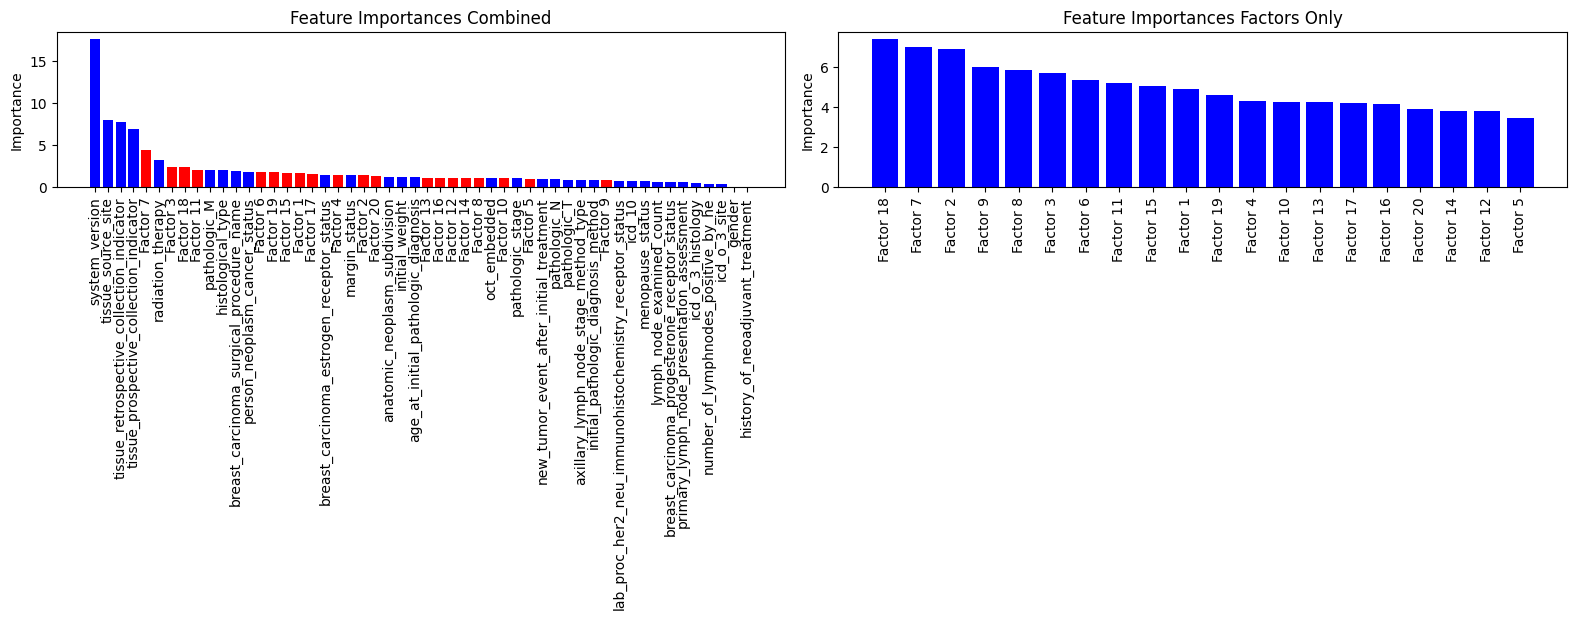

In [41]:
pca_metrics = regression_pipeline(pca_factors, *pipeline_args)

m_f_pca, m_c_pca, c_f_pca, c_c_pca = pca_metrics.values()

### UMAP

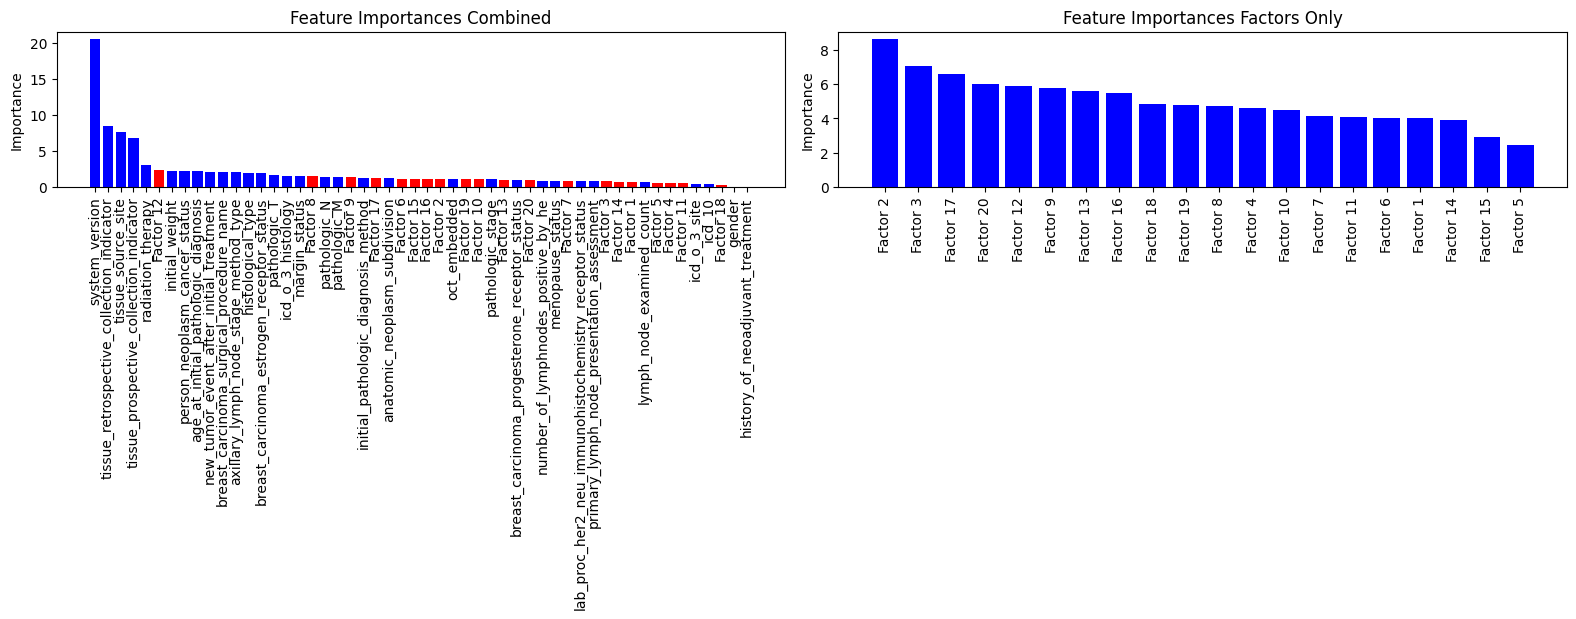

In [42]:
umap_metrics = regression_pipeline(umap_factors, *pipeline_args)

m_f_umap, m_c_umap, c_f_umap, c_c_umap = umap_metrics.values()

### Base Autoencoder

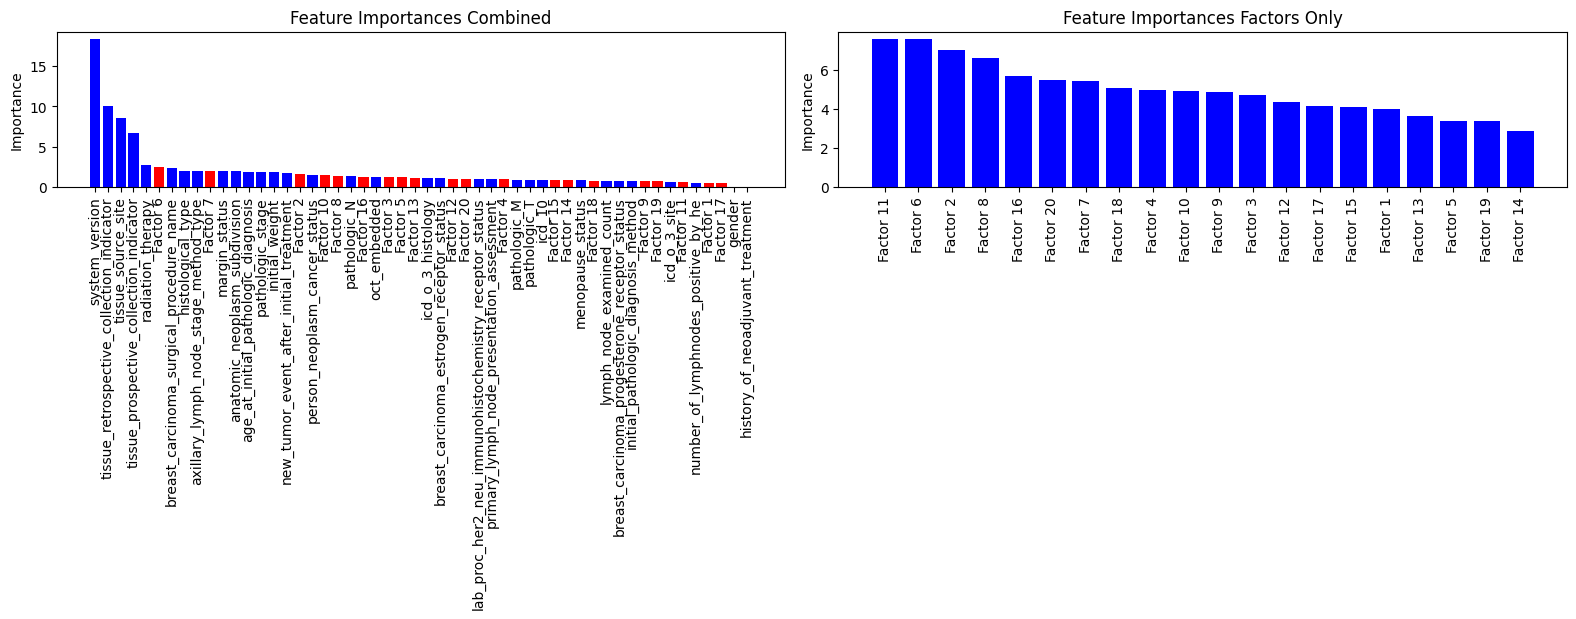

In [43]:
base_auto_metrics = regression_pipeline(base_autoenc_factors, *pipeline_args)

m_f_base_auto, m_c_base_auto, c_f_base_auto, c_c_base_auto = base_auto_metrics.values()

### Triple Autoencoder

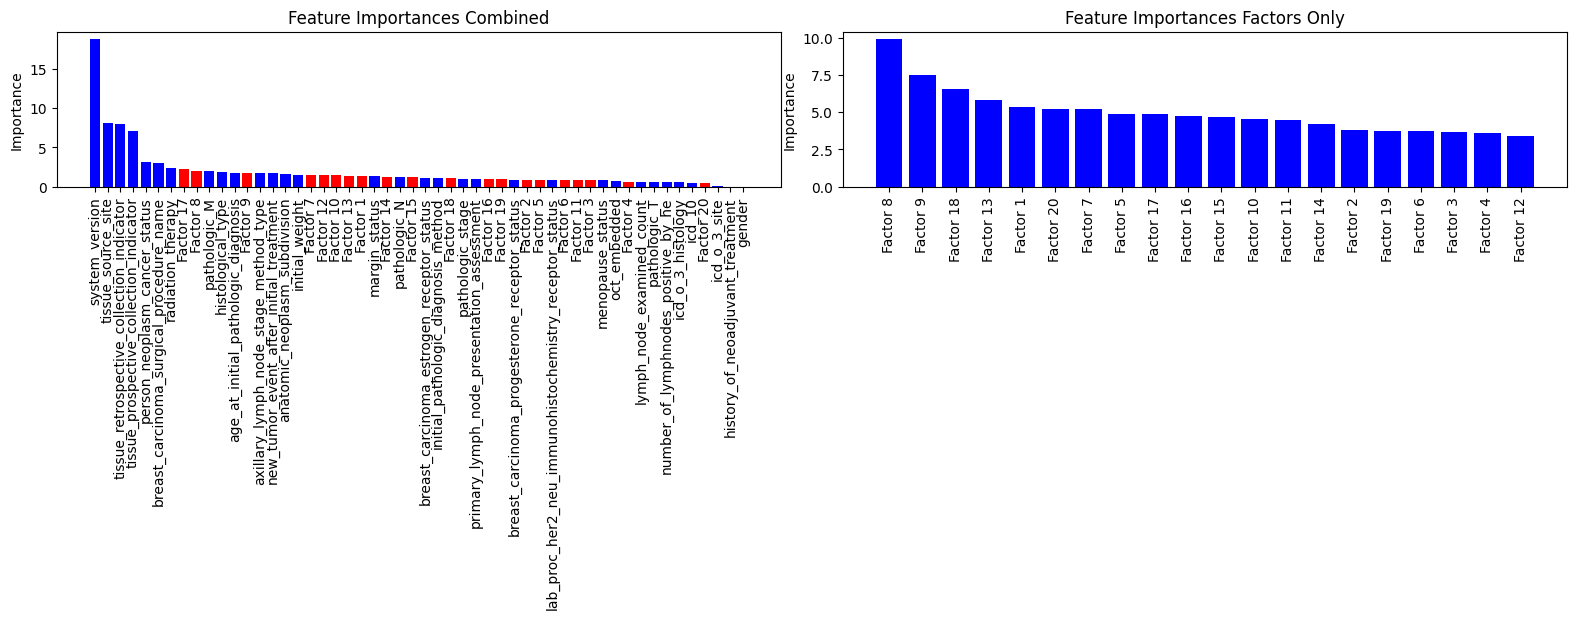

In [44]:
triple_auto_metrics = regression_pipeline(triple_autoenc_factors, *pipeline_args)

m_f_triple_auto, m_c_triple_auto, c_f_triple_auto, c_c_triple_auto = triple_auto_metrics.values()

### Регрессия, результаты:

In [47]:
regr_results = pd.DataFrame({
    'MAPE factors, %': [m_f_base, m_f_pca, m_f_umap, m_f_mofa, m_f_mcca, m_f_base_auto, m_f_triple_auto],
    'MAPE factors + clinical, %': [m_c_base, m_c_pca, m_c_pca, m_c_mofa, m_c_mcca, m_c_base_auto, m_c_triple_auto],
    'C-index censored, factors': [c_f_base, c_f_pca, c_f_umap, c_f_mofa, c_f_mcca, c_f_base_auto, c_f_triple_auto],
    'C-index censored, factors + clinical': [c_c_base, c_c_pca, c_c_umap, c_c_mofa, c_c_mcca, c_c_base_auto, c_c_triple_auto]
}, index=['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder'])

regr_results['Method Average'] = regr_results.mean(axis=1)
column_means = regr_results.iloc[:, :-1].mean(axis=0)
regr_results.loc['All Methods Average'] = column_means.tolist() + ['-']

regr_results

,"MAPE factors, %","MAPE factors + clinical, %","C-index censored, factors","C-index censored, factors + clinical",Method Average
No factorization,118.533504,94.062040,0.675839,0.628188,53.474893
PCA,129.658813,89.327190,0.614765,0.682550,55.07083
UMAP,146.786975,89.327190,0.524832,0.643624,59.320655
MOFA,133.588963,88.850371,0.636242,0.653020,55.932149
MCCA,127.750026,84.423155,0.648993,0.704027,53.38155
Base Autoencoder,145.014550,92.977947,0.608054,0.657047,59.814399
Triple Autoencoder,130.451964,90.058488,0.671141,0.645638,55.456808
All Methods Average,133.112114,89.860911,0.625695,0.659156,-


### *В задаче предсказания survival в по факторам, используя CatboostRegressor, лучше всего оказался Triple Autoencoder - по С-index censored и по среднему скору*

## Регрессия: Cox model, предсказание risk score

### Бейзлайн: без факторизации

In [49]:
%autoreload
base_cox_metrics = cox_regression_pipeline(X_breast_all, *cox_pipeline_args)
c_f_base_cox, c_c_base_cox = base_cox_metrics.values()

### MOFA

In [50]:
mofa_cox_metrics = cox_regression_pipeline(mofa_factors, *cox_pipeline_args)
c_f_mofa_cox, c_c_mofa_cox = mofa_cox_metrics.values()

### MCCA

In [51]:
mcca_cox_metrics = cox_regression_pipeline(mcca_factors, *cox_pipeline_args)
c_f_mcca_cox, c_c_mcca_cox = mcca_cox_metrics.values()

### PCA

In [52]:
pca_cox_metrics = cox_regression_pipeline(pca_factors, *cox_pipeline_args)
c_f_pca_cox, c_c_pca_cox = pca_cox_metrics.values()

### UMAP

In [53]:
umap_cox_metrics = cox_regression_pipeline(umap_factors, *cox_pipeline_args)
c_f_umap_cox, c_c_umap_cox = umap_cox_metrics.values()

### Base Autoencoder

In [54]:
cox_base_autoencoder_metrics = cox_regression_pipeline(base_autoenc_factors, *cox_pipeline_args)

c_f_base_auto_cox, c_c_base_auto_cox = cox_base_autoencoder_metrics.values()

### Triple Autoencoder

In [55]:
cox_triple_auto_metrics = cox_regression_pipeline(triple_autoenc_factors, *cox_pipeline_args)

c_f_triple_auto_cox, c_c_triple_auto_cox = cox_triple_auto_metrics.values()

In [56]:
cox_regr_results = pd.DataFrame({
    'C-index censored, factors': [c_f_base_cox, c_f_pca_cox, c_f_umap_cox, c_f_mofa_cox, c_f_mcca_cox, c_f_base_auto_cox, c_f_triple_auto_cox],
    'C-index censored, factors + clinical': [c_c_base_cox, c_c_pca_cox, c_c_umap_cox, c_c_mofa_cox, c_c_mcca_cox, c_c_base_auto_cox, c_c_triple_auto_cox]
}, index=['No factorization', 'PCA', 'UMAP', 'MOFA', 'MCCA', 'Base Autoencoder', 'Triple Autoencoder'])

cox_regr_results['Method Average'] = cox_regr_results.mean(axis=1)
means = cox_regr_results.iloc[:, :-1].mean(axis=0)
cox_regr_results.loc['All Methods Average'] = means.tolist() + ['-']

cox_regr_results

,"C-index censored, factors","C-index censored, factors + clinical",Method Average
No factorization,0.707383,0.734228,0.720805
PCA,0.669128,0.883893,0.77651
UMAP,0.548322,0.869799,0.70906
MOFA,0.647651,0.884564,0.766107
MCCA,0.575839,0.883893,0.729866
Base Autoencoder,0.640268,0.885235,0.762752
Triple Autoencoder,0.571141,0.872483,0.721812
All Methods Average,0.622819,0.859156,-


### *В задаче предсказания survival в по факторам, используя Cox Regression, лучше всего PCA по С-index censored*